In [ ]:
#Importing libraries
import os
import cv2
import shutil
import random
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.layers import Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import callbacks, layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Dense, Add, Lambda, Concatenate
# Notebook magic
%matplotlib inline

In [ ]:
# Check if GPU available
!nvidia-smi

Wed Oct 11 03:10:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    51W / 400W |    747MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Define Hyperparameters
input_shape = (224, 224, 3)
num_classes = 3
batch_size = 64

In [ ]:
# Define a function to load images and labels from a directory
def load_data_from_directory(directory):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith(".jpg"):  # Adjust file extension as needed
                img = cv2.imread(os.path.join(class_dir, filename))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, input_shape[:2])  # Resize to the desired input shape
                label = class_names.index(class_name)
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

In [ ]:
# Load train, validation, and test data
train_images, train_labels = load_data_from_directory('/content/drive/MyDrive/Training/Data/Data_file/train')
validation_images, validation_labels = load_data_from_directory('/content/drive/MyDrive/Training/Data/Data_file/val')
test_images, test_labels = load_data_from_directory('/content/drive/MyDrive/Training/Data/Data_file/test')

In [ ]:
# One-hot encode the class labels
train_labels_onehot = to_categorical(train_labels, num_classes=num_classes)
validation_labels_onehot = to_categorical(validation_labels, num_classes=num_classes)
test_labels_onehot = to_categorical(test_labels, num_classes=num_classes)

In [ ]:
# Define data generators for train, validation, and test sets
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Training/Data/Data_file/train',  # Train set
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True

)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)
validation_generator = val_datagen.flow_from_directory(
    '/content/drive/MyDrive/Training/Data/Data_file/val',  # Validation set
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False

)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Training/Data/Data_file/test',  # Test set
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 12069 images belonging to 3 classes.
Found 1705 images belonging to 3 classes.
Found 3433 images belonging to 3 classes.


In [ ]:
#Defining h-swish activation function
from keras import backend as K
from tensorflow.keras.utils import get_custom_objects
def my_function(x):
    return x * tf.nn.relu6(x+3) * 0.16666667
get_custom_objects().update({'my_function': Activation(my_function)})

In [ ]:
#Loading the model
from tensorflow.keras.applications import MobileNetV3Small

mobilenet_base_model = MobileNetV3Small(include_top=False,weights="imagenet",input_shape=(224, 224, 3))

#Making sure the layers of the MobileNet model are not retrained
for layer in mobilenet_base_model.layers:
    layer.trainable = False

In [ ]:
#Adding custom layers to the model
mobilenet_model = tf.keras.models.Sequential()
get_custom_objects().update({'my_function': Activation(my_function)})
mobilenet_model.add(mobilenet_base_model)
mobilenet_model.add(tf.keras.layers.Flatten())
mobilenet_model.add(tf.keras.layers.BatchNormalization())
mobilenet_model.add(tf.keras.layers.Dense(128,activation= my_function))
mobilenet_model.add(tf.keras.layers.Dropout(0.8))
mobilenet_model.add(tf.keras.layers.Dense(3,activation='softmax'))
mobilenet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 28224)             0         
                                                                 
 batch_normalization_3 (Bat  (None, 28224)             112896    
 chNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 128)               3612800   
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 3)                

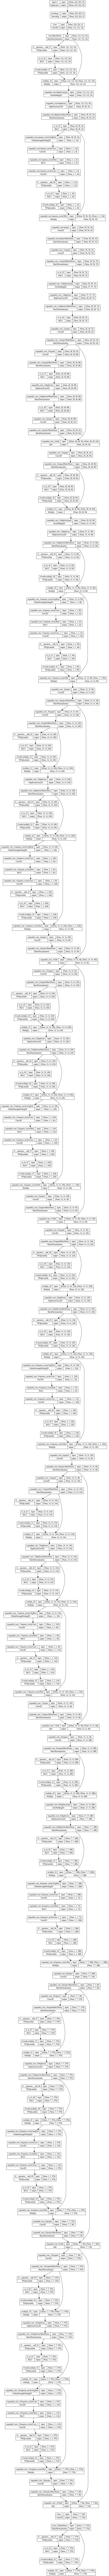

In [ ]:
from tensorflow.keras.utils import plot_model
# Visualize the model architecture and save it to a file
plot_model(mobilenet_base_model, to_file='mobilenetv3.png', show_shapes=True)

In [ ]:
# Create optimizer with custom parameters
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001, momentum=0.9, name='RMSprop')

mobilenet_model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [ ]:
# Define the early stopping and learning rate reduction callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10, restore_best_weights=True)
#learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience = 3)

In [ ]:
# Train the model
epochs = 100
history = mobilenet_model.fit(train_images,train_labels_onehot,batch_size=batch_size,epochs=epochs,
                    validation_data=(validation_images, validation_labels_onehot), #callbacks=[early_stopping]
)

Epoch 1/100
189/189 [==============================] - 8s 20ms/step - loss: 0.4675 - accuracy: 0.8702 - val_loss: 0.1081 - val_accuracy: 0.9713
Epoch 2/100
189/189 [==============================] - 2s 12ms/step - loss: 0.1796 - accuracy: 0.9518 - val_loss: 0.0828 - val_accuracy: 0.9754
Epoch 3/100
189/189 [==============================] - 2s 12ms/step - loss: 0.1494 - accuracy: 0.9640 - val_loss: 0.0918 - val_accuracy: 0.9777
Epoch 4/100
189/189 [==============================] - 2s 12ms/step - loss: 0.1340 - accuracy: 0.9718 - val_loss: 0.1160 - val_accuracy: 0.9754
Epoch 5/100
189/189 [==============================] - 2s 12ms/step - loss: 0.1347 - accuracy: 0.9739 - val_loss: 0.1306 - val_accuracy: 0.9748
Epoch 6/100
189/189 [==============================] - 2s 12ms/step - loss: 0.1394 - accuracy: 0.9760 - val_loss: 0.1366 - val_accuracy: 0.9789
Epoch 7/100
189/189 [==============================] - 2s 13ms/step - loss: 0.1403 - accuracy: 0.9792 - val_loss: 0.1615 - val_accuracy:

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = mobilenet_model.evaluate(test_images, test_labels_onehot, batch_size=8)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

430/430 [==============================] - 2s 6ms/step - loss: 0.3748 - accuracy: 0.9752
Test Loss: 0.3748
Test Accuracy: 0.9752


In [ ]:
# Generate confusion matrix
predicted_labels = mobilenet_model.predict(test_images)
predicted_labels = np.argmax(predicted_labels, axis=1)

108/108 [==============================] - 1s 6ms/step


In [ ]:
# Generate classification report
class_labels = sorted(os.listdir('/content/drive/MyDrive/Training/Data/Data_file/test'))  # Get class names from the test directory
report = classification_report(test_labels, predicted_labels, target_names=class_labels)
print(report)

                precision    recall  f1-score   support

BLACK_SIGATOKA       0.96      0.98      0.97      1154
 FUSARIUM_WILT       0.98      0.95      0.97      1152
       HEALTHY       0.99      0.99      0.99      1127

      accuracy                           0.98      3433
     macro avg       0.98      0.98      0.98      3433
  weighted avg       0.98      0.98      0.98      3433



In [ ]:
# Calculate accuracy
accuracy = accuracy_score(test_labels, predicted_labels)

# Calculate precision
precision = precision_score(test_labels, predicted_labels, average='weighted')

# Calculate recall
recall = recall_score(test_labels, predicted_labels, average='weighted')

# Calculate F1-score
f1 = f1_score(test_labels, predicted_labels, average='weighted')

# Print results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.9752403145936499
Precision: 0.975317328874905
Recall: 0.9752403145936499
F1-score: 0.9751955912779934


108/108 [==============================] - 1s 6ms/step


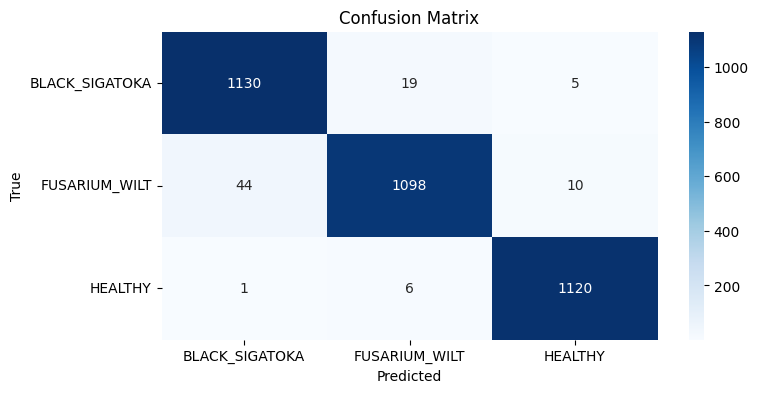

In [ ]:
confusion_mtx = confusion_matrix(test_labels, predicted_labels)
# Plot confusion matrix
plt.figure(figsize=(8, 4))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
# Generate confusion matrix
predicted_labels = mobilenet_model.predict(test_images)
predicted_labels = np.argmax(predicted_labels, axis=1)
plt.title('Confusion Matrix')
plt.show()

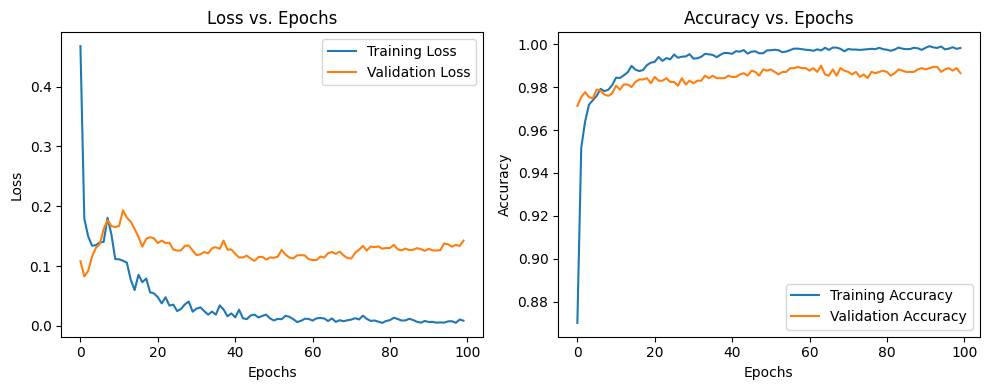

In [ ]:
#Plot loss graphs
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()